In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Q1)

#### Image Stitching

##### Method

- Detect SIFT feature matches
- Compute homography matrix
   
   
    - We have point correspondences from SIFT feature matching. We calculate the homography matrix H in the following way:

$$ 
\begin{bmatrix}
u'\\
v'\\
1 \\
\end{bmatrix} = H * \begin{bmatrix}
x\\
y\\
1
\end{bmatrix}$$


$$
H = 
\begin{bmatrix}
h_{11} & h_{12} & h_{13} \\
h_{21} & h_{22} & h_{23} \\
h_{31} & h_{32} & h_{33} \\
\end{bmatrix}
$$


$$
u' = \frac{h_{11}*x + h_{12}*y + h_{13}}{h_{31}*x + h_{32}*y + h_{33}} \\ 
v' = \frac{h_{21}*x + h_{22}*y + h_{23}}{h_{31}*x + h_{32}*y + h_{33}}
$$
    - From the above equations we have the following:

$$
h_{11}*x + h_{12}*y + h_{13} - u' * (h_{31}*x + h_{32}*y + h_{33}) = 0 \\
h_{21}*x + h_{22}*y + h_{23} - v' * (h_{31}*x + h_{32}*y + h_{33}) = 0
$$


    - To obtain values of H matrix we stack the values in row wise. We then formulate the following matrix to solve for H. We get the below matrix for each point correspondence. We require at least 4 point correspondences as there are 8 degrees of freedom.
    
$$
\begin{bmatrix}
x & y & 1 & 0 & 0 & 0 & -u'*x & -u'*y & -u' \\
0 & 0 & 0 & x & y & 1 & -v'*x & -v'*y & -v' \\
\end{bmatrix}
$$
    - After stacking the above obtained matrix with other matrices for at least 4 point correspondences we take the SVD. We choose the eigenvector corresponding to the lowest eigen value as the row vector H as this minimizes our error. We later reshape this to 3 x 3 to obtain homography matrix.

- After obtaining the Homography matrix we use warp perspective to transform image from one to the other and stitch.

- The following code iterates over 20000 time to get the appropriate inliers to get the appropriate homography matrix.

In [2]:

def ORBfeatures(img1, img2):
    '''
    Code to get SIFT point correspondences
    '''
#     orb = cv2.ORB_create(nfeatures = 500)
    orb = cv2.xfeatures2d.SIFT_create(nfeatures=500)
    
    
    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    # brute force point matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
#     Draw first 10 matches.
#     img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches, None)
#     plt.imshow(img3)
#     plt.show()
    points_1 = np.empty((1,3))
    points_2 = np.empty((1,3))

    # print(points_1)
    for mat in matches:

        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # print(kp1[img1_idx].pt)
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt


        points_1 = np.vstack((points_1, np.array([[x1, y1, 1]])))
        points_2 = np.vstack((points_2, np.array([[x2, y2, 1]])))


    points_1 = points_1[1:,:]
    points_2 = points_2[1:,:]

    # print(points_1)
    
    return points_1, points_2



def getHomographyMatrix(points_1, points_2):
    '''
    Function to get homography matrix between images
    '''
    
    homographyIntermediate = np.zeros((2*points_1.shape[0], 9))
    
    for i in range(points_1.shape[0]):
        
        
        x = points_2[i, 0]
        y = points_2[i, 1]
        xTransform = points_1[i, 0]
        yTransform = points_1[i, 1]
        
        homographyIntermediate[2*i, :] = np.array([x, y, 1, 0, 0, 0, -xTransform*x, -xTransform*y, -xTransform])
        homographyIntermediate[2*i + 1, :] = np.array([0, 0, 0, x, y, 1, -yTransform*x, -yTransform*y, -yTransform])

    U, S, Vt = np.linalg.svd(homographyIntermediate)
    
    homographyMatrix = Vt[ -1, :]
#     print(homographyMatrix)
    homographyMatrix = np.reshape(homographyMatrix, (3,3))
#     homographyMatrix = homographyMatrix / homographyMatrix[2,2]
#     print(homographyMatrix)
    
    return homographyMatrix

def getHomographyRansac(img1, img2, numIterations, threshold):
    
    '''
    RANSAC based implementation to compute best homography matrix between the two images that maximizes number of inliers
    '''
    inliersinArray = 0
    points_img1, points_img2 = ORBfeatures(img1, img2)
    for i in range(numIterations):
        
        
        idx = np.random.randint(points_img1.shape[0], size=4)
        
        # calculating homography
        H = getHomographyMatrix(points_img1[idx, :], points_img2[idx, :])
        
        # projecting points
        points_img2_transformed = H @ points_img2.T
        points_img2_transformed = points_img2_transformed / points_img2_transformed[2,:]
        
        error = np.sum(np.square(points_img1.T - points_img2_transformed), axis = 0)
        error = np.sqrt(error)
#         print(error)
        inLiers = error < threshold
        numOfInliers = np.sum(inLiers)
#         print(numOfInliers)

        if numOfInliers > inliersinArray:
            
            inliersinArray = numOfInliers
            homographyMatrix = H
            
    print(inliersinArray)
    print('Calculated homography matrix \n', homographyMatrix)
    return homographyMatrix

def getTranslation(H, img1, img2):
    
    height = img1.shape[0]
    width = img1.shape[1]
    corners = np.array([[0,      0, width,  width],
                        [0, height,     0, height],
                        [1,      1,     1,      1]])
    image1_transform = np.linalg.inv(H) @ corners

    height = img2.shape[0]
    width = img2.shape[1]
    corners = np.array([[0,      0, width,  width],
                        [0, height,     0, height],
                        [1,      1,     1,      1]])
    image2_transform = (H) @ corners
    image2_transform = image2_transform / image2_transform[2,:]
    print(image2_transform)
    
    val = image2_transform.min(axis = 1)
    return val
#     val = np.minimum(image2_transform)
#     print(val)

    
def cropImage(image, threshold):
    '''
    Function that crops the black rows and columns out of image
    '''
    
    mask = image>threshold
    if image.ndim==3:
        mask = mask.all(2)
    
    mask0 = mask.any(0)
    mask1 = mask.any(1)

    return image[np.ix_(mask1,mask0)]

def combinedImage(image1, image2):
    '''
    Function to combine images 1 and 2
    '''
    mask = (image1 != 0)
    tempImage = image2[0:image1.shape[0], 0:image1.shape[1],:]
    tempImage[mask] = image1[mask]
    image2[0:tempImage.shape[0], 0:tempImage.shape[1]] = tempImage
    
    return cropImage(image2, 20)
#     return image2
    
def stitchImages(img1, img2):
    
    H = getHomographyRansac(img1, img2, 20000, 0.1)    
    warpedImage = cv2.warpPerspective(img2, H, (img1.shape[1] + img2.shape[1], img1.shape[0] + img2.shape[0]))  
    combined_image = combinedImage(img1, warpedImage)
    return combined_image

def stitchSequence(imageDir, seq_id):
    
    files = []
    filesInit = 'img%d' % seq_id
    for i in os.listdir(imageDir):
        if os.path.isfile(os.path.join(imageDir,i)) and filesInit in i:
            files.append(i)  
    
    files.sort()
    imagePath = imageDir + files[0]
    img1 = cv2.imread(imagePath)
    
    for name in range(1, len(files)):
        
        imagePath = imageDir + files[name]
        img2 = cv2.imread(imagePath)
        
        img1 = stitchImages(img1, img2)
        plt.imshow(img1)
        plt.show()
    plt.title('Final stitched image')    
    plt.imshow(img1)
    plt.show()
    return img1

## Q2)

### Part a)

Cross correlation matching of images

In [4]:
def computeNormCorrelation(patch, imagePatch):
    '''
    Function to compute normalized cross correlation between patches
    '''
    
    
    patch = patch - patch.mean()
    imagePatch = imagePatch - imagePatch.mean()
    
    crossCorrelation = np.sum(patch * imagePatch)
    sumPatch = np.sum(np.square(patch))
    sumImagePatch = np.sum(np.square(imagePatch))
    

    normalizedCrossCorrelation = crossCorrelation / np.sqrt(sumPatch * sumImagePatch)
    
    
    return normalizedCrossCorrelation
    
def getMatchedWindowLocation(patch, image, stride = 16):
    '''
    Gives the location of maximum correlation between patch and image
    
    Input:
        image - H x W - black and white image
        patch - H x W - black and white patch to search in image
        stride - scalar - stride value
    Returns:
        u - scalar - pixel location for matched patch along dimension 1
        v - scalar - pixel location for matched patch along dimension 2
    '''
    
    heightPatch = patch.shape[0]
    widthPatch = patch.shape[1]
    correlationLocationMatrix = np.zeros(((image.shape[0] - patch.shape[0]), (image.shape[1] - patch.shape[1]))) 
    
    
    for i in range(0, image.shape[0] - heightPatch, stride):
        for j in range(0, image.shape[1] - widthPatch, stride):
            
            
            normalizedCorrelation = computeNormCorrelation(patch, image[i:i + heightPatch, j:j + widthPatch])
            correlationLocationMatrix[i, j] = normalizedCorrelation
            
    maxCorrelation = np.max(correlationLocationMatrix)
#     print(maxCorrelation)
#     print(np.where(correlationLocationMatrix == maxCorrelation))
    return np.where(correlationLocationMatrix == maxCorrelation) 
            
def showGrayImage(img):
    
    plt.imshow(img, 'gray')
    plt.show()

def windowMatching(img1, img2, window_size = 32, stride = 16):
    '''
    Cross correlation window matching
    '''
#     matchMatrix = np.zeros((img1.shape[0], img1.shape[1],2))
    matchMatrix = []
    center = int(window_size / 2)
    for i in range(0, img1.shape[0] - window_size, window_size):
        for j in range(0, img1.shape[1] - window_size, window_size):
            
            patch = img1[i:i + window_size, j:j + window_size]
            location = getMatchedWindowLocation(patch, img2, stride)
#             print(patch.shape)
            matchMatrix.append([(i + center, j + center), (location[0][0] + center, location[1][0] + center)])
    
    
    return matchMatrix

def displayIntensityMatchResult(imageLeft, imageRight, matchMatrix):
    
    plt.imshow(imageLeft, 'gray')
    colors = np.random.rand(len(matchMatrix),3)

    for i in range(len(matchMatrix)):
        pointObject = matchMatrix[i]
        tuple1 = pointObject[0]
        tuple2 =  pointObject[1]
        c = colors[i]
        plt.scatter(tuple1[1], tuple1[0], color = c)

    plt.show()

    plt.imshow(imageRight, 'gray')

    for i in range(len(matchMatrix)):
        pointObject = matchMatrix[i]
        tuple1 = pointObject[0]
        tuple2 =  pointObject[1]
        c = colors[i]
        plt.scatter(tuple2[1], tuple2[0], color = c)

    plt.show()
    
def divideImage(image):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imageLeft = image[:, :int(image.shape[1] / 2)]
    imageRight = image[:, int(image.shape[1] / 2) :]
    
    return imageLeft, imageRight



In [80]:
def stereoRectification(image1, image2):
    
    points_1, points_2 = ORBfeatures(image1, image2)
    points_1 = points_1[:,:2]
    points_2 = points_2[:,:2]
    fundamental = cv2.findFundamentalMat(points_1, points_2)

    F = fundamental[0]
    maskF = fundamental[1]
    
    # selecting inliers for rectification
    inliers = maskF == 1
    inliers.shape = (inliers.shape[0],)
    points_1 = points_1[inliers,:]
    points_2 = points_2[inliers,:]
    
    
    H = cv2.stereoRectifyUncalibrated(points_1.ravel(), points_2.ravel(), F, (image1.shape[1], image1.shape[0]))

    warpedImage1 = cv2.warpPerspective(image1, H[1], (image1.shape[1], image1.shape[0]))  

    H = cv2.stereoRectifyUncalibrated(points_2.ravel(), points_1.ravel(), F, (image2.shape[1], image2.shape[0]))
    warpedImage2 = cv2.warpPerspective(image2, H[1], (image2.shape[1], image2.shape[0]))  

    showGrayImage(warpedImage1)
    showGrayImage(warpedImage2)

In [106]:
def getEpipolarlines(image1, image2):
    
    
    points_1, points_2 = ORBfeatures(image1, image2)
    points_1 = points_1[:,:2]
    points_2 = points_2[:,:2]
    fundamental = cv2.findFundamentalMat(points_1, points_2)

    F = fundamental[0]
    maskF = fundamental[1]
    
    # selecting inliers for rectification
    inliers = maskF == 1
    inliers.shape = (inliers.shape[0],)
    points_1 = points_1[inliers,:]
    points_2 = points_2[inliers,:]
    
    line1 = cv2.computeCorrespondEpilines(points_2, 2, F)
    line2 = cv2.computeCorrespondEpilines(points_1, 1, F)
    
    
    return line1, line2

def windowMatchingLine(row, patch, image, stride=16):
    
    
    height = patch.shape[0]
    width = patch.shape[1]
    
    correlationRow = np.zeros((image.shape[1]))
    
    for x in range(0, image.shape[1] - width, stride):

#             x = -(y * line[1] + line[2]) / line[0]
        normalizedCrossCorrelation = computeNormCorrelation(patch, image[row:row + height, x:x + width])
        correlationRow[x] = normalizedCrossCorrelation
    
    maxValue = np.max(correlationRow)
    col = np.where(correlationRow == maxValue)
#     print(col)
    
    return col[0][0]
            
    
def matchingUsingEpipolarLines(image1, image2, window_size = 64, stride = 16):
    
#     line1, line2 = getEpipolarlines(image1, image2)
    matchLocations = []
    center = window_size / 2
    for i in range(0, image1.shape[0] - window_size, stride):
        for j in range(0, image1.shape[1] - window_size, stride):
#             print(i, j)
            patch = image1[i:i + window_size, j:j + window_size]
            Location = windowMatchingLine(i, patch, image2, stride)
#             print(Location)
            matchLocations.append([(i + center, j + center), (i + center, Location + center)])
    
    displayIntensityMatchResult(image1, image2, matchLocations)

    
# def longestCommonSubsequenceMatch(image1, image2, window_size = 64, stride = 16):
    
    

### Q1 Results

Performing image stitching on the given images

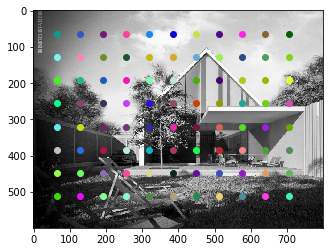

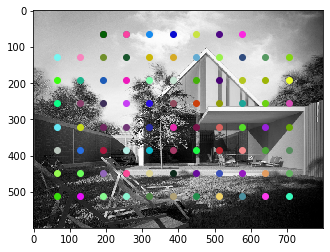

In [107]:
if __name__ == "__main__":
    
    seq_id = 1
    imageDir = './images/image_mosaicing/'
    stitchSequence(imageDir, seq_id)
    

    

In [ ]:
    imageDir2 = './images/stereo_images/'
    imageId = 1
    imageFile = '%d.jpg' % imageId
    imagePath = imageDir2 + imageFile
    
    image = cv2.imread(imagePath)
    imageLeft, imageRight = divideImage(image)
    
    window_size = 128
    stride = 64
#     matchMatrix = windowMatching(imageLeft, imageRight, window_size, stride)
#     displayIntensityMatchResult(imageLeft, imageRight, matchMatrix)
#     stereoRectification(imageLeft, imageRight)    
#     getEpipolarlines(imageLeft, imageRight)
    matchingUsingEpipolarLines(imageLeft, imageRight, window_size, stride)
#     print(matchLocations)
    
    
    imageId = 2
    imageFile = '%d.jpg' % imageId
    imagePath = imageDir2 + imageFile
    
    image = cv2.imread(imagePath)
    imageLeft, imageRight = divideImage(image)
    
    window_size = 32
    stride = 16
#     matchMatrix = windowMatching(imageLeft, imageRight, window_size, stride)
#     displayIntensityMatchResult(imageLeft, imageRight, matchMatrix)
    stereoRectification(imageLeft, imageRight)    


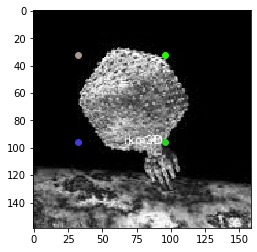

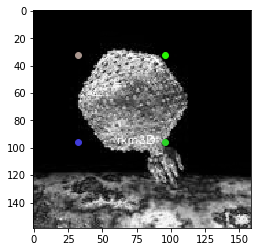

In [77]:
    imageId = 3
    imageFile = '%d.jpeg' % imageId
    imagePath = imageDir2 + imageFile
    
    image = cv2.imread(imagePath)
    imageLeft, imageRight = divideImage(image)
    window_size = 64
    stride = 16
    matchMatrix = windowMatching(imageLeft, imageRight, window_size, stride)
    displayIntensityMatchResult(imageLeft, imageRight, matchMatrix)


### Part b) Stereo rectification and intensity based matching

In [20]:
    stereoRectification(imageLeft, imageRight)

[[ 58.33377838  32.29468918   1.        ]
 [ 72.42599487 110.73743439   1.        ]
 [ 47.63808823  94.97673798   1.        ]
 [132.82626343 130.57479858   1.        ]
 [ 86.21107483  40.02831268   1.        ]
 [ 98.95874786 107.371315     1.        ]
 [ 50.05058289 126.8736496    1.        ]
 [ 61.95700836  89.67111206   1.        ]
 [ 74.90977478  65.39797974   1.        ]
 [114.18269348 143.03770447   1.        ]
 [114.50272369 146.57322693   1.        ]
 [ 68.08952332  29.72912598   1.        ]
 [ 44.14313507  81.578125     1.        ]
 [ 25.16588593 144.95776367   1.        ]
 [101.73188782 145.43638611   1.        ]
 [ 36.328228   136.97598267   1.        ]
 [ 66.51403809 143.7038269    1.        ]
 [ 95.3747406  115.63424683   1.        ]
 [ 35.70617294 140.79853821   1.        ]
 [ 92.81589508 137.63633728   1.        ]
 [ 39.40320969 116.77879333   1.        ]
 [129.58650208 138.12762451   1.        ]
 [ 25.75210381 128.07417297   1.        ]
 [ 75.61011505 143.31864929   1.  